In [ ]:
# Import libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import math
import cv2
import random
import copy

import torchvision.transforms.functional as F
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision.utils import _log_api_usage_once

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.manual_seed(2)
np.random.seed(3)
random.seed(4)

# Import data

In [3]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./test.csv')
id_lookup_data = pd.read_csv('IdLookupTable.csv')

# Inspecting data

In [4]:
print(train_data.shape, test_data.shape)

(7049, 31) (1783, 2)


In [5]:
train_data.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...


In [6]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


<Axes: >

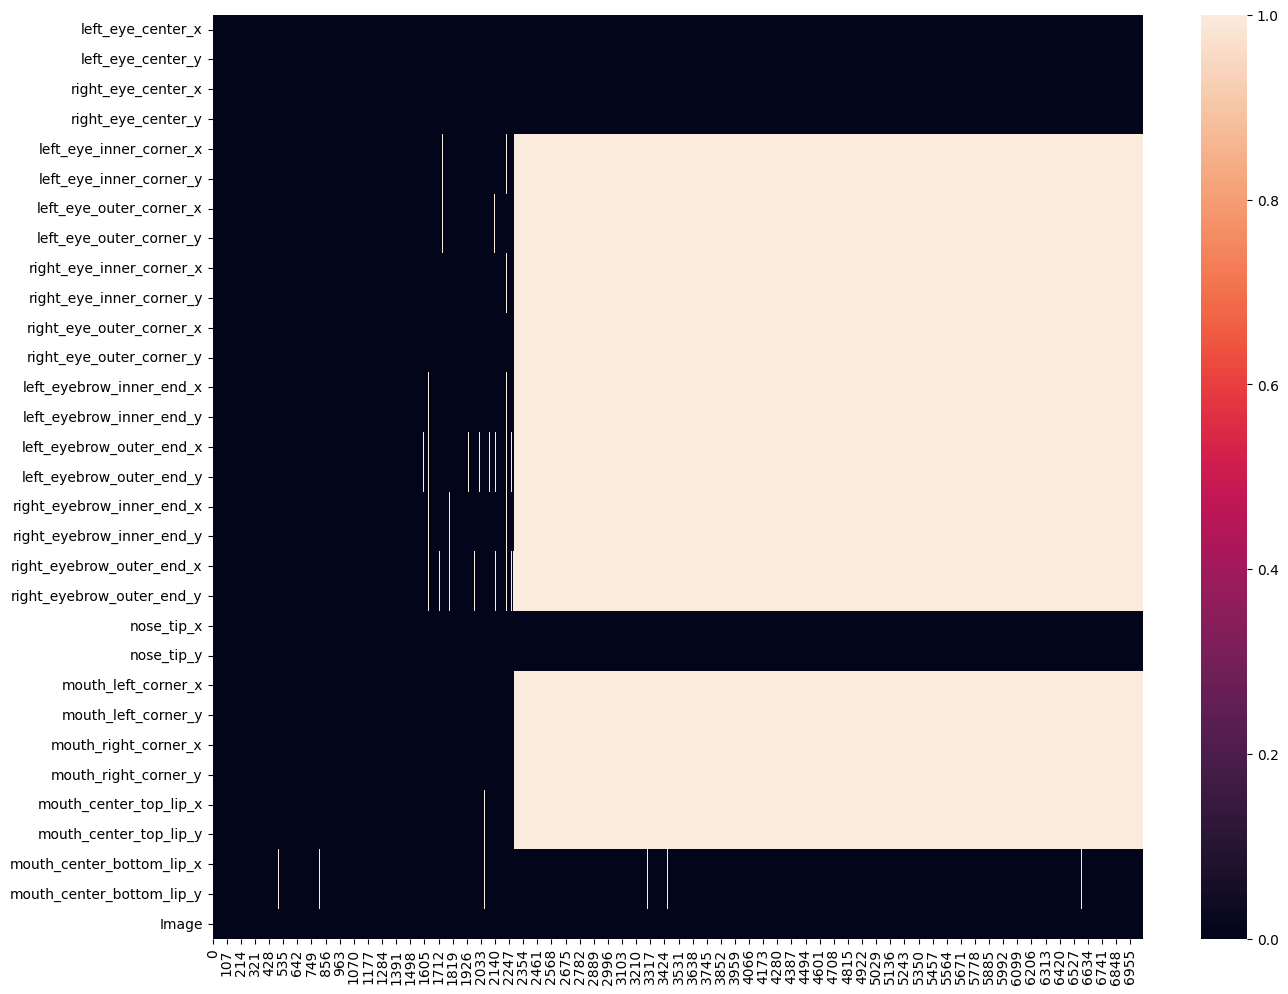

In [9]:
plt.subplots(figsize=(15,12))
sns.heatmap(train_data.isna().T)

A lot of data missing

# Data preprocessing

## Some functions that come later in use

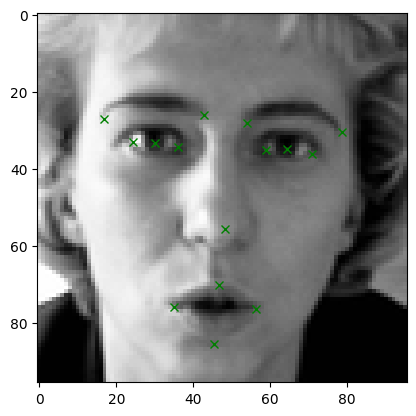

In [10]:
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints


def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'gx')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)
    
show_image_with_keypoints_by_id(train_data, 1)

## Duplicates

In [11]:
duplicates = train_data.duplicated(subset = 'Image', keep='last')
print(f"There are {sum(duplicates)} duplicates.")
duplicates_list = [g for _, g in train_data.groupby("Image") if len(g) > 1]       

There are 555 duplicates.


In [12]:
duplicates_df = pd.concat(duplicates_list)
duplicates_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098 entries, 3648 to 4846
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          1098 non-null   float64
 1   left_eye_center_y          1098 non-null   float64
 2   right_eye_center_x         1098 non-null   float64
 3   right_eye_center_y         1098 non-null   float64
 4   left_eye_inner_corner_x    2 non-null      float64
 5   left_eye_inner_corner_y    2 non-null      float64
 6   left_eye_outer_corner_x    2 non-null      float64
 7   left_eye_outer_corner_y    2 non-null      float64
 8   right_eye_inner_corner_x   2 non-null      float64
 9   right_eye_inner_corner_y   2 non-null      float64
 10  right_eye_outer_corner_x   1 non-null      float64
 11  right_eye_outer_corner_y   1 non-null      float64
 12  left_eyebrow_inner_end_x   2 non-null      float64
 13  left_eyebrow_inner_end_y   2 non-null      float64

Looks like most of them are from the smaller subset (only basic features).

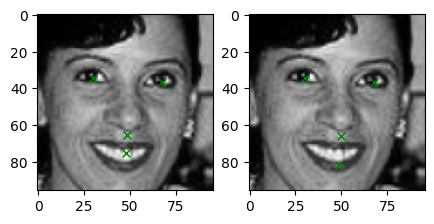

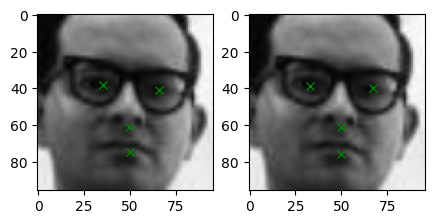

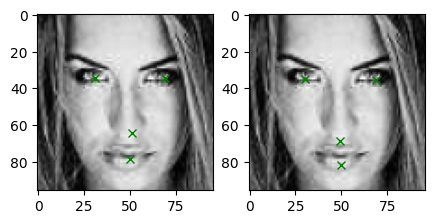

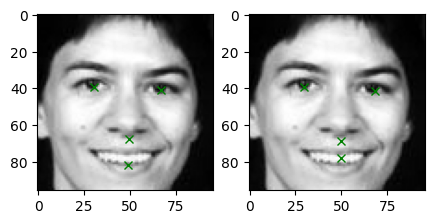

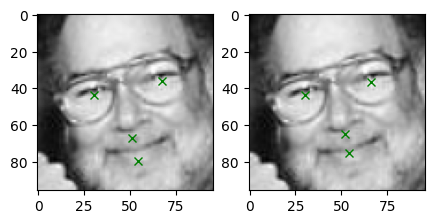

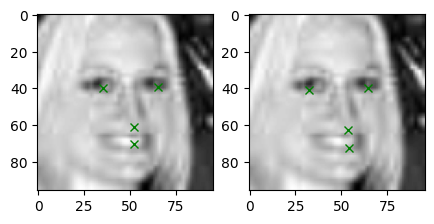

In [13]:
pics_num = 6
for duplicate_df in duplicates_list[:pics_num]:
    n_rows = len(duplicate_df)
    fig = plt.figure(figsize=(5, 5*n_rows))
#     print(n_rows)
    i = 1
    for index, row in duplicate_df.iterrows():        
        image, keypoints = get_image_and_keypoints(row)
        fig.add_subplot(1, n_rows, i)
        plt.imshow(image, cmap='gray')
        plt.plot(keypoints[:,0], keypoints[:,1], 'gx')
        i += 1
    plt.show()

There is no good way of autimatically pick from possible options. Therefore I will remove all duplicates. Then add new row containing lower point of bottom lip and average of eyes and nose point.

In [14]:
for duplicate_df in duplicates_list:
        n_rows = len(duplicate_df)
        keypoints_list = []
        image = None
        indexes = []
        for index, row in duplicate_df.iterrows():
            image = row['Image']
            indexes.append(index)
            keypoints_df = pd.DataFrame(row).drop(['Image'], axis=0).values
            keypoints_list.append(keypoints_df)

        keypoints_list = np.array(keypoints_list)
        keypoints_list = keypoints_list.reshape((n_rows, 30,))
        # New keypoint as average of all duplicates
        new_keypoints = np.nanmean(keypoints_list, dtype=np.float64, axis=0)
        index_lowest_lip = np.argmax(keypoints_list, axis=0)[-1]
        # Bottom lip from the lowest point in duplicates
        new_keypoints[-1] = keypoints_list[index_lowest_lip, -1]
        new_keypoints[-2] = keypoints_list[index_lowest_lip, -2]
        # Concat keypoints with image
        new_row = new_keypoints.tolist()
        new_row.append(image)
        
        # Delete all duplicates
        train_data.drop(index=indexes, inplace=True)
        # Add new row
        train_data.loc[max(train_data.index) + 1] = new_row

In [15]:
del duplicates, duplicates_df, duplicates_list

In [16]:
train_data.reset_index(drop=True, inplace=True)

## Missing data

* alter loss function - when expected value equals to NaN, it zeroes the loss.


In [17]:
def NaNMSELoss(output, target):
    filter = ~torch.isnan(target)
    return ((output[filter] - target[filter]) ** 2).mean()

# Dataset

Dataset will be constructed with PyTorch's Dataset. It returns dict:
* 'image' containing 96x96 image with values from 0 to 1; in addition, the photos will have 3 channels (RGB) and not 1,
* 'keypoints' containing all 30 keypoints (as floats or NaNs).

Additionally all images with corresponding keypoints were extracted once in Dataset's constructor to unburden CPU and fasten training.

In [18]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transforms=None):
        self.df = dataframe
        self.transforms = transforms
        
        self.images = []
        self.keypoints = []
        
        for index, row in self.df.iterrows():
            # Image
            image = row['Image']
            image = np.fromstring(image, sep=' ').reshape([96, 96])
            image = np.stack((image, image, image), axis=-1)
            image = image / 255.0
            
            # Keypoints
            keypoints = row.drop(['Image'])
            keypoints = keypoints.to_numpy().astype('float32')
            
            # Add to Dataset's images and keypoints
            self.images.append(image)
            self.keypoints.append(keypoints)

    def __getitem__(self, idx):
#         item: pd.Series = self.df.iloc[idx]

#         # Image
#         image = item['Image']
#         image = np.fromstring(image, sep=' ').reshape([96, 96])
#         image = np.stack((image, image, image), axis=-1)
#         image = image / 255.0

#         # Keypoints
#         keypoints = item.drop(['Image'])
#         keypoints = keypoints.to_numpy().astype('float32')


        image = self.images[idx]
        keypoints = self.keypoints[idx]
        
        return_dict = {'image': image, 'keypoints': keypoints}

        if self.transforms:
            return_dict = self.transforms(return_dict)

        return return_dict

    def __len__(self):
        return len(self.df)

7049


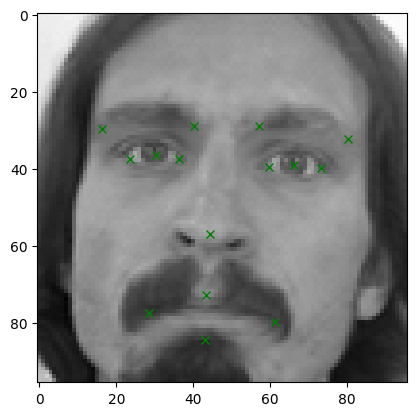

In [19]:
dataset = FacialKeypointsDataset(pd.read_csv('./training.csv'))
print(len(dataset))
datapoint = dataset[0]
# print(datapoint)
img = datapoint['image']
keypoints = datapoint['keypoints']
plt.imshow(img, cmap='gray')
plt.plot(keypoints[0::2], keypoints[1::2], 'gx')
plt.show()

# Augmentation

## Augmentation classes

### Helper functions

In [20]:
def rotate_point(origin, point, angle):
    xo, yo = origin
    xp, yp = point

    x_final = xo + math.cos(math.radians(angle)) * (xp - xo) - math.sin(math.radians(angle)) * (yp - yo)
    y_final = yo + math.sin(math.radians(angle)) * (xp - xo) + math.cos(math.radians(angle)) * (yp - yo)
    return x_final, y_final


def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


def translate_image(image, translate):
    y, x = image.shape[0], image.shape[1]

    xp = x * translate[0]
    yp = y * translate[1]

    M = np.float32([[1, 0, xp], [0, 1, yp]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return shifted

### Random Vertical Flip

In [21]:
class MyRandomVerticalFlip(object):
    def __init__(self, p=0.5):
        super().__init__()
        _log_api_usage_once(self)
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        self.p = p

    def __call__(self, img_with_keypoints):
        if torch.rand(1) < self.p:
            image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]

            # Image
            # new_image = F.vflip(image)
            new_image = np.fliplr(image)

            # Keypoints
            width_img = image.shape[0]
            old_keypoints = keypoints
            new_keypoints = np.copy(keypoints)
            # left eye center x, y
            new_keypoints[0] = width_img - old_keypoints[2]
            new_keypoints[1] = old_keypoints[3]
            # right eye center x, y
            new_keypoints[2] = width_img - old_keypoints[0]
            new_keypoints[3] = old_keypoints[1]
            # left eye inner corner x, y
            new_keypoints[4] = width_img - old_keypoints[8]
            new_keypoints[5] = old_keypoints[9]
            # left eye outer corner x, y
            new_keypoints[6] = width_img - old_keypoints[10]
            new_keypoints[7] = old_keypoints[11]
            # right eye inner corner x, y
            new_keypoints[8] = width_img - old_keypoints[4]
            new_keypoints[9] = old_keypoints[5]
            # right eye outer corner x, y
            new_keypoints[10] = width_img - old_keypoints[6]
            new_keypoints[11] = old_keypoints[7]
            # left eyebrow inner end x, y
            new_keypoints[12] = width_img - old_keypoints[16]
            new_keypoints[13] = old_keypoints[17]
            # left eyebrow outer end x, y
            new_keypoints[14] = width_img - old_keypoints[18]
            new_keypoints[15] = old_keypoints[19]
            # right eyebrow inner end x, y
            new_keypoints[16] = width_img - old_keypoints[12]
            new_keypoints[17] = old_keypoints[13]
            # right eyebrow outer end x, y
            new_keypoints[18] = width_img - old_keypoints[14]
            new_keypoints[19] = old_keypoints[15]
            # nose tip x, y
            new_keypoints[20] = width_img - old_keypoints[20]
            # new_keypoints[21] = old_keypoints[21]
            # mouth left corner x, y
            new_keypoints[22] = width_img - old_keypoints[24]
            new_keypoints[23] = old_keypoints[25]
            # mouth right corner x, y
            new_keypoints[24] = width_img - old_keypoints[22]
            new_keypoints[25] = old_keypoints[23]
            # mouth center top lip x, y
            new_keypoints[26] = width_img - old_keypoints[26]
            # new_keypoints[27] = old_keypoints[27]
            # mouth center bottom lip x, y
            new_keypoints[28] = width_img - old_keypoints[28]
            # new_keypoints[29] = old_keypoints[29]

            return {'image': new_image, 'keypoints': new_keypoints}

        return img_with_keypoints

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

### Random Rotation

In [22]:
class MyRandomRotation(object):
    def __init__(self, angle: int, p=0.5):
        super().__init__()
        _log_api_usage_once(self)
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        self.p = p
        self.angle = angle

    def __call__(self, img_with_keypoints):
        if torch.rand(1) < self.p:
            angle = np.random.randint(-self.angle, self.angle)
            # angle = np.random.triangular(-self.angles, 0, self.angles)
            image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]

            # Image rotation
            # new_image = F.vflip(image)
            new_image = rotate_image(image, -angle)

            # Keypoints rotation
            width, height = image.shape[0], image.shape[1]
            origin = (width / 2, height / 2)
            new_keypoints = np.copy(keypoints)
            for i, point in enumerate(keypoints.reshape(15, 2)):
                new_point = rotate_point(origin, point, angle)
                new_keypoints[i * 2] = new_point[0]
                new_keypoints[i * 2 + 1] = new_point[1]

            return {'image': new_image, 'keypoints': new_keypoints}

        return img_with_keypoints

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

### Random Translation

In [23]:
class MyRandomTranslation(object):
    def __init__(self, translate: (float, float), p=0.5):
        """

        :type translate: (float, float) x, y translate in percent - from 0 to 1
        """
        super().__init__()
        _log_api_usage_once(self)
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        if not (len(translate) == 2 and (0.0 <= translate[0] <= 1.0) and (0.0 <= translate[1] <= 1.0)):
            raise ValueError("there should be 2 numbers in translate, both between 0 and 1")
        self.p = p
        self.translate = translate

    def __call__(self, img_with_keypoints):
        if torch.rand(1) < self.p:
            image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]

            height, width = image.shape[0], image.shape[1]

            # x_translate_rate = np.random.triangular(-self.translate[0], 0, self.translate[0])
            # y_translate_rate = np.random.triangular(-self.translate[1], 0, self.translate[1])
            x_translate_rate = np.random.uniform(low=-self.translate[0], high=self.translate[0])
            y_translate_rate = np.random.uniform(low=-self.translate[1], high=self.translate[1])
            x_translate_pixel = width * x_translate_rate
            y_translate_pixel = height * y_translate_rate

            # Image rotation
            M = np.float32([[1, 0, x_translate_pixel], [0, 1, y_translate_pixel]])
            shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

            # Keypoints rotation
            new_keypoints = np.copy(keypoints)
            for i in range(len(keypoints) // 2):
                new_keypoints[2 * i] = keypoints[2 * i] + x_translate_pixel
                new_keypoints[2 * i + 1] = keypoints[2 * i + 1] + y_translate_pixel

            return {'image': shifted, 'keypoints': new_keypoints}

        return img_with_keypoints

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

### Random Brightness

In [24]:
class MyRandomBrightnessAdjust(object):
    def __init__(self, brightness: float, p=0.5):
        super().__init__()
        _log_api_usage_once(self)
        if not (isinstance(p, float) and (0.0 <= p <= 1.0)):
            raise ValueError("probability should be float between 0 and 1")
        if not (0.0 <= brightness <= 1.0):
            raise ValueError("brightness should be float between 0 and 1")
        self.p = p
        self.brightness = brightness

    def __call__(self, img_with_keypoints):
        if torch.rand(1) < self.p:
            image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]
            random_brightness = np.random.uniform(low=-self.brightness, high=self.brightness)

            # Image rotation
            hsv = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)

            lim = 255 - random_brightness
            v[v > lim] = 255
            v[v <= lim] += random_brightness

            final_hsv = cv2.merge((h, s, v))
            img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
            img = np.clip(img, 0.0, 1.0)

            # Keypoints rotation

            return {'image': img, 'keypoints': keypoints}

        return img_with_keypoints

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

## test augmentation

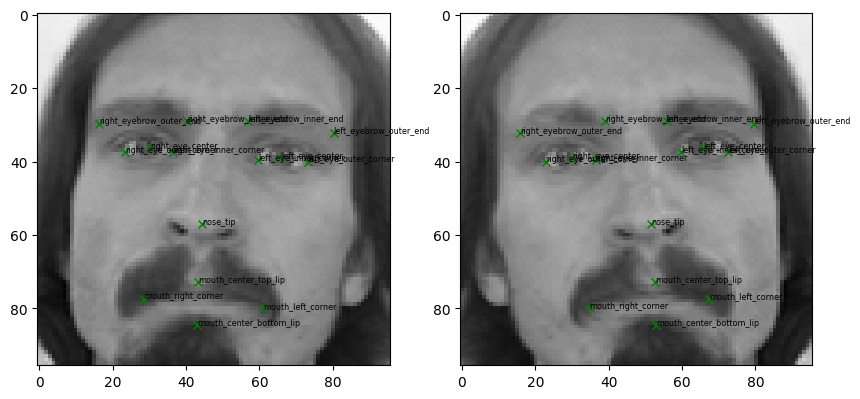

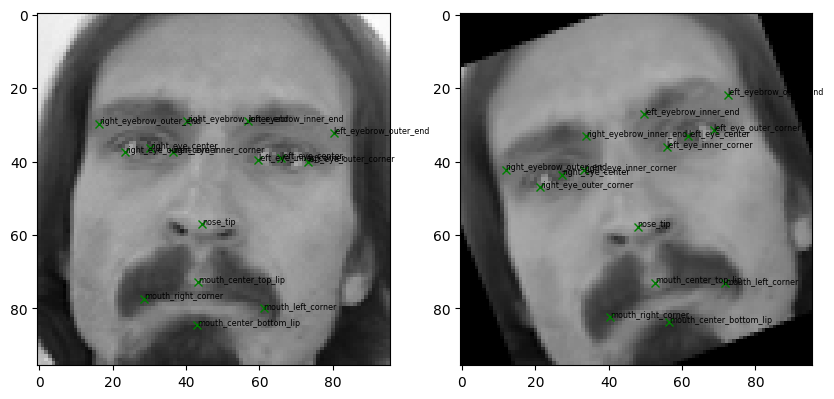

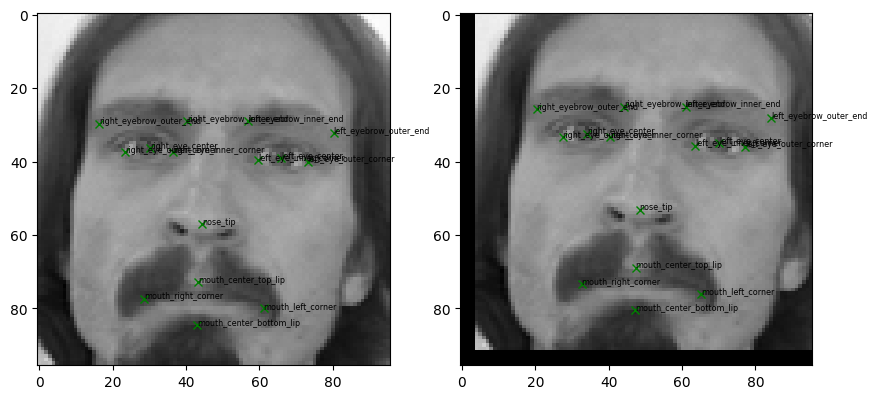

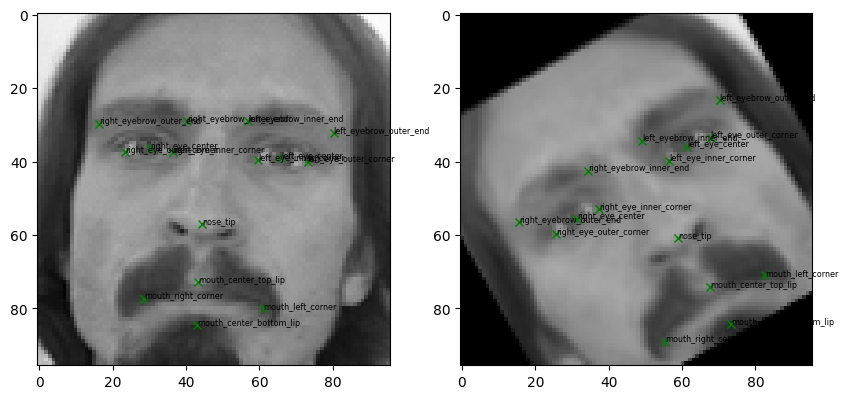

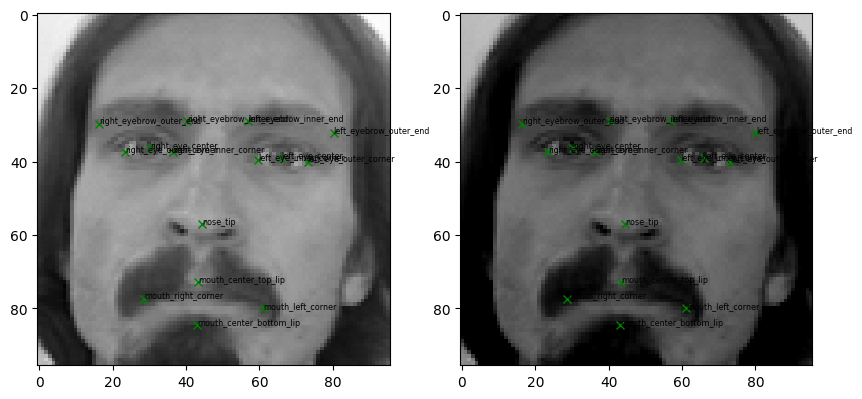

In [25]:
data = pd.read_csv('./training.csv')
columns_keypoints = data.columns[:-1]
# dataset = FacialKeypointsDataset(data)

datapoint = dataset[0]
image, keypoints = datapoint['image'], datapoint['keypoints']

random_flip = MyRandomVerticalFlip(p=1.0)
random_rotation = MyRandomRotation(p=1.0, angle=45)
random_translation = MyRandomTranslation(translate=(0.1, 0.1), p=1.0)
random_brightness = MyRandomBrightnessAdjust(brightness=0.2, p=1.0)

transform_flip = random_flip(datapoint)
transform_rotation = random_rotation(datapoint)
transform_translation = random_translation(datapoint)
transform_combined = random_flip(random_rotation(random_translation(datapoint)))
transform_brightness = random_brightness(datapoint)

transforms_list = [transform_flip, transform_rotation, transform_translation, transform_combined, transform_brightness]

for transformed_image_with_keypoints in transforms_list:
    transformed_image = transformed_image_with_keypoints["image"]
    transformed_keypoints = transformed_image_with_keypoints["keypoints"]

    fig = plt.figure(figsize=(10, 20))
    # Plot original image
    fig.add_subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    for i, keypoint_name in enumerate(columns_keypoints[::2]):
        plt.annotate(keypoint_name[:-2],
                     (keypoints[2 * i], keypoints[2 * i + 1]),
                     fontsize='xx-small')
    plt.plot(keypoints.reshape((15, 2))[:, 0],
             keypoints.reshape((15, 2))[:, 1], 'gx')
    # Plot flipped image
    fig.add_subplot(1, 2, 2)
    plt.imshow(transformed_image, cmap='gray')
    for i, keypoint_name in enumerate(columns_keypoints[::2]):
        plt.annotate(keypoint_name[:-2],
                     (transformed_keypoints[2 * i], transformed_keypoints[2 * i + 1]),
                     fontsize='xx-small')
    plt.plot(transformed_keypoints.reshape((15, 2))[:, 0],
             transformed_keypoints.reshape((15, 2))[:, 1], 'gx')

    plt.show()

## ToTensor (PyTorch)


In [26]:
class MyToTensor(object):

    def __call__(self, img_with_keypoints):
        image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]
        image = np.transpose(image, (2, 0, 1)).copy()

        image = torch.from_numpy(image).type(torch.FloatTensor)
        keypoints = torch.from_numpy(keypoints).type(torch.FloatTensor)

        return {'image': image, 'keypoints': keypoints}

# Evaluating

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [28]:
BATCH_SIZE = 64
EPOCHS = 120
EPOCHS_PRETRAIN = 25

## Preparation

### Model

ResNet18

In [ ]:
#model = torchvision.models.resnet18(pretrained=True)

#model.fc = torch.nn.Linear(model.fc.in_features, 30)

#model = model.type(torch.FloatTensor)
#model = model.to(device)

VGG16

In [29]:
model = torchvision.models.vgg16(pretrained=True)

num_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(num_features, 30)

model = model.type(torch.FloatTensor)
model = model.to(device)

### Transforms

In [30]:
train_transform = torchvision.transforms.Compose([
     MyRandomVerticalFlip(p=0.5),
     MyRandomRotation(angle=35, p=0.33),
     MyRandomTranslation(translate=(0.12, 0.12), p=0.33),
     MyRandomBrightnessAdjust(brightness=0.2, p=0.5),
     MyToTensor()
    ])

val_transform = torchvision.transforms.Compose([MyToTensor()])

### Dataset

In [31]:
#uncomment the line if you want without the trasformation
#dataset = FacialKeypointsDataset(pd.read_csv('./training.csv'),transforms=None)

train_size = int(len(dataset) * 0.85)
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_set.dataset.transforms = train_transform
val_set.dataset.transforms = val_transform

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=BATCH_SIZE)

## Pre train

At the beginning of training ResNet18 will train only the last full-connected layer (regression), which we added earlier. For this purpose, we will turn off PyTorch's requires_grad for all layers except the last one.

In [32]:
*previous_layers, last_layer = model.parameters()

In [33]:
for layer in previous_layers:
    layer.requires_grad = False

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.001)

In [35]:
logger = {'train': [], 'val': []}

train_steps = len(train_set) / BATCH_SIZE
val_steps = len(val_set) / BATCH_SIZE

for epoch in range(EPOCHS_PRETRAIN):
    torch.manual_seed(1 + epoch)

    print(f"EPOCH: {epoch + 1}/{EPOCHS_PRETRAIN}")

    model.train()
    train_loss = 0.0
    for (batch_idx, sample) in enumerate(train_loader):
        x = sample['image']
        y = sample['keypoints']
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = NaNMSELoss(pred, y)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        for val_sample in val_loader:
            x = val_sample['image']
            y = val_sample['keypoints']
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            val_loss += NaNMSELoss(pred, y)

    avg_train_loss = train_loss / val_steps
    avg_val_loss = val_loss / val_steps

    logger["train"].append(avg_train_loss.cpu().detach().numpy())
    logger["val"].append(avg_val_loss.cpu().detach().numpy())
    print(f"Average train loss: {avg_train_loss:.6f}, Average validation loss: {avg_val_loss:.6f}")


logger_df = pd.DataFrame(logger)
logger_df.to_csv('logger2.csv')

EPOCH: 1/25
Average train loss: 13151.947266, Average validation loss: 1970.382446
EPOCH: 2/25
Average train loss: 9191.651367, Average validation loss: 1367.734375
EPOCH: 3/25
Average train loss: 6341.933594, Average validation loss: 937.223083
EPOCH: 4/25
Average train loss: 4336.183594, Average validation loss: 637.366150
EPOCH: 5/25
Average train loss: 2939.629883, Average validation loss: 430.058380
EPOCH: 6/25
Average train loss: 1979.361816, Average validation loss: 288.375000
EPOCH: 7/25
Average train loss: 1326.035034, Average validation loss: 193.142639
EPOCH: 8/25
Average train loss: 884.855225, Average validation loss: 127.972572
EPOCH: 9/25
Average train loss: 592.583008, Average validation loss: 86.626205
EPOCH: 10/25
Average train loss: 402.085388, Average validation loss: 59.439716
EPOCH: 11/25
Average train loss: 279.645447, Average validation loss: 42.260838
EPOCH: 12/25
Average train loss: 204.418961, Average validation loss: 31.473328
EPOCH: 13/25
Average train loss

PermissionError: [Errno 13] Permission denied: 'logger.csv'

Turn ability to learn back on.

In [39]:
logger_df = pd.DataFrame(logger)
logger_df.to_csv('logger2.csv')

In [36]:
for layer in previous_layers:
    layer.requires_grad = True

## Train loop

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.00005)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 25, 40, 65], gamma=0.1)

In [42]:
logger = {'train': [], 'val': []}


best_model = None
min_val_loss = np.inf

train_steps = len(train_set) / BATCH_SIZE
val_steps = len(val_set) / BATCH_SIZE

for epoch in range(EPOCHS):
    torch.manual_seed(1 + epoch)

    print(f"EPOCH: {epoch + 1}/{EPOCHS}")

    model.train()
    train_loss = 0.0
    for (batch_idx, sample) in enumerate(train_loader):
        x = sample['image']
        y = sample['keypoints']
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = NaNMSELoss(pred, y)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        for val_sample in val_loader:
            x = val_sample['image']
            y = val_sample['keypoints']
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            val_loss += NaNMSELoss(pred, y)

    scheduler.step()

    avg_train_loss = train_loss / val_steps
    avg_val_loss = val_loss / val_steps

    logger["train"].append(avg_train_loss.cpu().detach().numpy())
    logger["val"].append(avg_val_loss.cpu().detach().numpy())
    print(f"Average train loss: {avg_train_loss:.6f}, Average validation loss: {avg_val_loss:.6f}")
    
    if min_val_loss > val_loss:
        min_test_loss = val_loss
        best_model = copy.deepcopy(model)


logger_df = pd.DataFrame(logger)
logger_df.to_csv('logger2.csv')

EPOCH: 1/120
Average train loss: 81.272125, Average validation loss: 15.267281
EPOCH: 2/120
Average train loss: 63.939457, Average validation loss: 8.940121
EPOCH: 3/120
Average train loss: 44.663818, Average validation loss: 7.180996
EPOCH: 4/120
Average train loss: 33.550369, Average validation loss: 5.457123
EPOCH: 5/120
Average train loss: 29.098709, Average validation loss: 4.538701
EPOCH: 6/120
Average train loss: 22.291769, Average validation loss: 4.091682
EPOCH: 7/120
Average train loss: 20.027563, Average validation loss: 4.019123
EPOCH: 8/120
Average train loss: 19.229731, Average validation loss: 3.927235
EPOCH: 9/120
Average train loss: 18.212879, Average validation loss: 4.295307
EPOCH: 10/120


KeyboardInterrupt: 

In [41]:
best_model.to(device)

AttributeError: 'NoneType' object has no attribute 'to'

## Loss visualization

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(logger_df["train"]*train_steps/len(train_set), label="train_loss")
plt.plot(logger_df["val"]*val_steps/len(val_set), label="val_loss")
# plt.ylim(0, 0.5)
plt.title("Training loss for VGG16")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
print(min(logger_df["val"]))

In [ ]:
print(logger_df)

## Showcase trained model

In [ ]:
IMAGES_TO_SHOW = 10
val_images_idxs = np.random.randint(0, len(val_set) - 1, 10)
transform = MyToTensor()
best_model.eval()
for idx in val_images_idxs:
    sample = val_set[idx]
    image = sample['image'].to(device)
    keypoints = sample['keypoints']
    with torch.no_grad():
        pred_keypoints = best_model(image.unsqueeze(0)).cpu().detach().numpy().reshape((30,))
    
    plt.imshow(image.cpu().detach().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.plot(pred_keypoints[0::2], pred_keypoints[1::2], 'wo')
    plt.plot(keypoints[0::2], keypoints[1::2], 'gx')
    plt.show()


# Submission

In [ ]:
id_lookup_data.head(3)

In [ ]:
test_data.head(3)

In [ ]:
sample_submission = pd.read_csv('../input/facial-keypoints-detection/SampleSubmission.csv')
sample_submission.head()

In [ ]:
print(len(id_lookup_data), len(sample_submission))

In [ ]:
columns_keypoints = data.columns[:-1]
for column in columns_keypoints:
    test_data[str(column)] = 0.0
test_data.head()

In [ ]:
for i, column in enumerate(columns_keypoints):
    print(i, column)

In [ ]:
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

best_model.eval()

In [ ]:
for row_idx, test_row in test_data.iterrows():
    image = test_row['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96])
    image = np.stack((image, image, image), axis=-1)
    image = image / 255.0
    image = test_transform(image)
    image = image.unsqueeze(0)
    image = image.type(torch.FloatTensor)
    image = image.to(device)
    
    with torch.no_grad():
        pred_keypoints = best_model(image).cpu().detach().numpy().reshape((30,))
        
    for column_idx, column in enumerate(columns_keypoints):
        test_data.at[row_idx, column] = pred_keypoints[column_idx]
test_data.head()

In [ ]:
sample_submission['Location'] = 0.0
for i, submission_row in sample_submission.iterrows():
    row_id = submission_row['RowId']
    feature_name = id_lookup_data[id_lookup_data['RowId'] == row_id]['FeatureName'].values[0]
    image_id = id_lookup_data[id_lookup_data['RowId'] == row_id]['ImageId'].values[0]
    sample_submission.at[i, 'Location'] = test_data[test_data['ImageId'] == image_id][feature_name]

In [ ]:
sample_submission.to_csv('./submission.csv', index=False)